In [1]:
# Some useful libraries - also allowing the entire dataframe to get printed out

import pandas as pd
import numpy as np
import math 
import seaborn as sns
from scipy import stats 
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt

pd.set_option('display.max_rows', 5000)

In [2]:
# Cleaning up the data - no draft picks outside the 2nd round, no players without stats
# Data from basketball-reference.com - thanks!

draft = pd.read_csv('NBA_Draft_data.csv')
draft = draft[draft['Rd'] < 3]
draft = draft[pd.isnull(draft['WS/48']) == False]
draft = draft[draft['Pk'] < 61]
draft['Age'] = round(draft['Age'])

Text(0.5,1,'Draft Pick # vs WS Per 48 Mins')

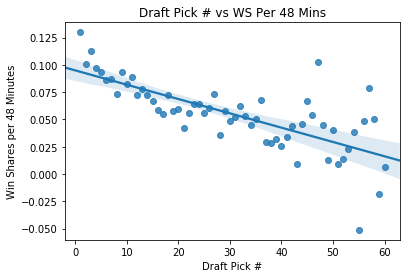

In [3]:
# Let's take a look at the pick number vs Win Shares per 48 minutes

pick_ws48 = draft.groupby(['Pk'])['WS/48'].mean()
pick_ws48 = pd.DataFrame(pick_ws48)
pick_ws48['Pick'] = pick_ws48.index

ax = sns.regplot(x="Pick", y="WS/48", data=pick_ws48)
ax.set(xlabel='Draft Pick #', ylabel='Win Shares per 48 Minutes')
ax.set_title("Draft Pick # vs WS Per 48 Mins")

In [4]:
# Let's take a look at the pick number vs Win Shares Total

pick_ws = draft.groupby(['Pk'])['WS'].mean()
pick_ws = pd.DataFrame(pick_ws)
pick_ws['Pick'] = pick_ws.index

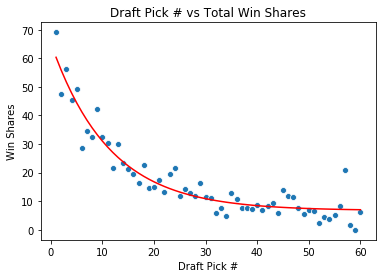

In [5]:
def func(x, a, b, c):
    return a * np.exp(-b * x) + c

popt, pcov = curve_fit(func, pick_ws['Pick'], pick_ws['WS'])

ax = sns.scatterplot(x="Pick", y="WS", data=pick_ws)
ax.set(xlabel='Draft Pick #', ylabel='Win Shares')
ax.set_title("Draft Pick # vs Total Win Shares")
plt.plot(pick_ws['Pick'], func(pick_ws['Pick'], *popt), 'r-', label='fit: a=%5.3f, b=%5.3f, c=%5.3f' % tuple(popt))

In [6]:
# Smoothen WS values
pick_ws['SmoothWS'] = (popt[0] * np.exp(-popt[1] * pick_ws['Pick'])) + popt[2]

In [7]:
# For a pick #, what are the average total WS and WS/48

def giveAvgWS(pick):
    return round(pick_ws[pick_ws['Pick'] == pick]['SmoothWS'].mean(), 2)

def giveAvgWS48(pick):
    return round(pick_ws[pick_ws['Pick'] == pick]['WS/48'].mean(), 2)

In [8]:
# Let's make some evaluations
# IF THE RESULT IS NEGATIVE, TEAM 1 WINS THE TRADE

def evalTradeWS(team1picks, team2picks):
    team1WS = 0
    for pick in team1picks:
        team1WS += giveAvgWS(pick)
    
    team2WS = 0
    for pick in team2picks:
        team2WS += giveAvgWS(pick)
        
    if team1WS > team2WS:
        return team1WS - team2WS
    
    else:
        return team1WS - team2WS
    
def whoWins(team1picks, team2picks):
    val = evalTradeWS(team1picks, team2picks)
    if val < 0:
        print('team 1 wins')
    else:
        print('team 2 wins')

In [9]:
whoWins([15, 16], [14, 17])

team 1 wins


In [10]:
# This isn't that useful  
def evalTradeWS48(team1picks, team2picks):
    team1WS = 0
    for pick in team1picks:
        team1WS += giveAvgWS48(pick)
    
    team2WS = 0
    for pick in team2picks:
        team2WS += giveAvgWS48(pick)
        
    if team1WS > team2WS:
        return team1WS - team2WS
    
    else:
        return team1WS - team2WS

In [20]:
# Let's try to make the trades fair
def makeMoreFair(team1picks, team2picks): 
    # Get the difference in the trade
    diff = evalTradeWS(team1picks, team2picks)
    team1Wins = True
    team2Wins = True
    
    # If the difference is positive, team 2 loses the trade
    if diff > 0: 
        team1Wins = False

    else:
        team2Wins = False
        
    # Say team 1 is winning the trade
    if team1Wins == True: 
        # Loop through the rows
        shouldBreak = False
        for index, row in pick_ws[::-1].iterrows():
            pickAdd = row['Pick']
            if pickAdd not in team1picks:
                team1picks.append(pickAdd)
                team1picks = list(dict.fromkeys(team1picks))
                newDiff = (evalTradeWS(team1picks, team2picks))
                # Is the new difference better? 
                if newDiff > 0 and pickAdd != 60:
                    print('Give team two the', pickAdd + 1, 'pick')
                    shouldBreak = True
                    
                elif newDiff > 0 and pickAdd == 60:
                    print('This is the best deal possible')
                    shouldBreak = True
                
                else:
                    team1picks.remove(pickAdd)    
                    
            if shouldBreak == True:
                break
    elif team2Wins == True:
        # Loop through the rows
        shouldBreak = False
        for index, row in pick_ws[::-1].iterrows():
            pickAdd = row['Pick']
            if pickAdd not in team2picks:
                team2picks.append(pickAdd)
                team2picks = list(dict.fromkeys(team2picks))
                newDiff = (evalTradeWS(team1picks, team2picks))
                # Is the new difference better? 
                if newDiff < 0 and pickAdd != 60:
                    print('Give team one the', pickAdd + 1, 'pick')
                    shouldBreak = True
                elif newDiff < 0 and pickAdd == 60:
                    print('This is the best deal possible')
                    shouldBreak = True
                else:
                    team2picks.remove(pickAdd)    
                
            if shouldBreak == True:
                break
        

In [21]:
# Here is an unfair trade where team 1 is getting ripped off - the number reported is the 
# difference in win shares between the two pick packages
evalTradeWS([8], [15, 41])

5.0

In [24]:
# Let's make this more fair!
makeMoreFair([1], [60])

Give team one the 3.0 pick


In [23]:
# Now here's the new trade's difference in win shares
evalTradeWS([8], [15, 41, 60])

-2.030000000000001